## RNAseq data normalization and transformation

In [1]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("tximportData")

In [19]:
options(warn=-1)
library(tools)
library("DESeq2")
library("dplyr")
library("ggplot2")
library('hexbin')
library("pheatmap")
library("RColorBrewer")
library("PoiClaClu")
library("repr")
library("edgeR")
library("tximportData")
options(warn=0)

### User specified variables here!

In [15]:
#specify infiles
countsfile <- '~/Desktop/A10_v2.1_STAR_Alignments/SingleSample_KallistoExpression_CombinedTranscriptsToOneGene.txt'
conditionsfile <- '~/Desktop/Kallisto_conditions.txt'
basename = file_path_sans_ext(countsfile)

#outfiles printed to same directory as countsfile
norm_outfil = paste(basename, '_normalized.matrix', sep = '')
normVst_outfil = paste(basename, '_normalized_vst_transformed.matrix', sep = '')
lowVar_outfil = paste(basename, '.genes_with_low_variance.txt', sep = '')
lowExp_outfil = paste(basename, '.genes_with_low_variance.txt', sep = '')

# set some minimum expression thresholds
min_per_sample <- 10
min_per_gene <- 5
min_variance <- 0.1

### Create expression matrices 

In [ ]:
countmatrix <- read.table(countsfile, sep="\t", header=TRUE)
coldata <- read.table(conditionsfile, sep="\t", header=TRUE)

In [6]:
# round non-integer counts provided by kallisto to nearest integer 
intmatrix <- round(countmatrix)

In [7]:
dds = DESeqDataSetFromMatrix(countData = intmatrix, colData = coldata, design = ~ condition)
dds <- estimateSizeFactors(dds)
vsd <- vst(dds, blind = FALSE)

write.table(assay(vsd), normVst_outfil, sep="\t", quote = FALSE)
write.table(counts(dds, normalized=TRUE), norm_outfil, sep="\t", quote = FALSE)


converting counts to integer mode
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]


### Get list of genes with no or very low expression

In [16]:

df_binary <- counts(dds)
df_binary[df_binary < min_per_sample] <- 0
df_binary[df_binary > 0] <- 1

lowExpGenes <- row.names(df_binary[ rowSums(df_binary) < min_per_gene, ])
write(lowExpGenes, file = lowExp_outfil, ncolumns = 1)

### Get list of genes with low variance 
calculated using the variance stabilized matrix



In [17]:
varCutoff <- nrow(dds[ apply(assay(vsd), 1, var) <= min_variance, ])
lowVarGenes <- head(order(rowVars(assay(vsd)), decreasing = FALSE), varCutoff)
lowVarGenes  <- row.names(counts(dds, normalized=TRUE)[ lowVarGenes, ])
write(lowVarGenes, file = lowVar_outfil, ncolumns = 1)

In [18]:
'number of genes with low expression'
length(lowExpGenes)

'number of genes with low variance'
length(lowVarGenes)

'number of genes with low variance AND low expression'
length(intersect(lowVarGenes, lowExpGenes))

[1] "number of genes with low expression"

[1] 14606

[1] "number of genes with low variance"

[1] 14160

[1] "number of genes with low variance AND low expression"

[1] 13957

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
Warning message:
“`as_data_frame()` is deprecated, use `as_tibble()` (but mind the new semantics).
This warning is displayed once per session.”

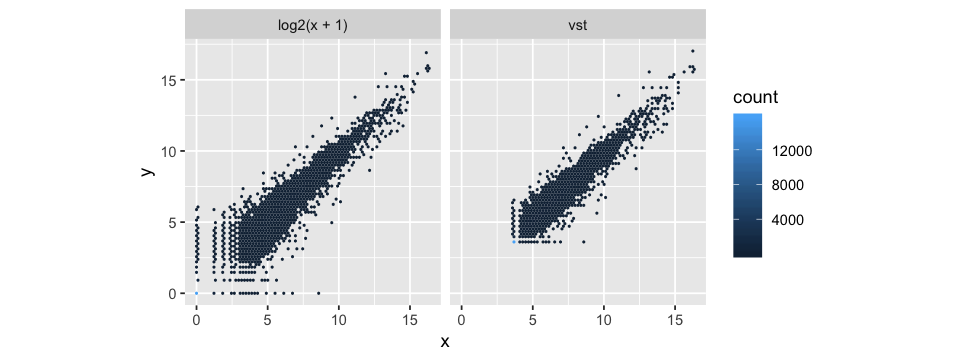

In [11]:
options(repr.plot.width=8, repr.plot.height=3)

dds <- estimateSizeFactors(dds)
df <- bind_rows(as_data_frame(log2(counts(dds, normalized=TRUE)[, 1:2]+1)) %>% mutate(transformation = "log2(x + 1)"), as_tibble(assay(vsd)[, 1:2]) %>% mutate(transformation = "vst"))
colnames(df)[1:2] <- c("x", "y")  
ggplot(df, aes(x = x, y = y)) + geom_hex(bins = 80) + coord_fixed() + facet_grid( . ~ transformation)

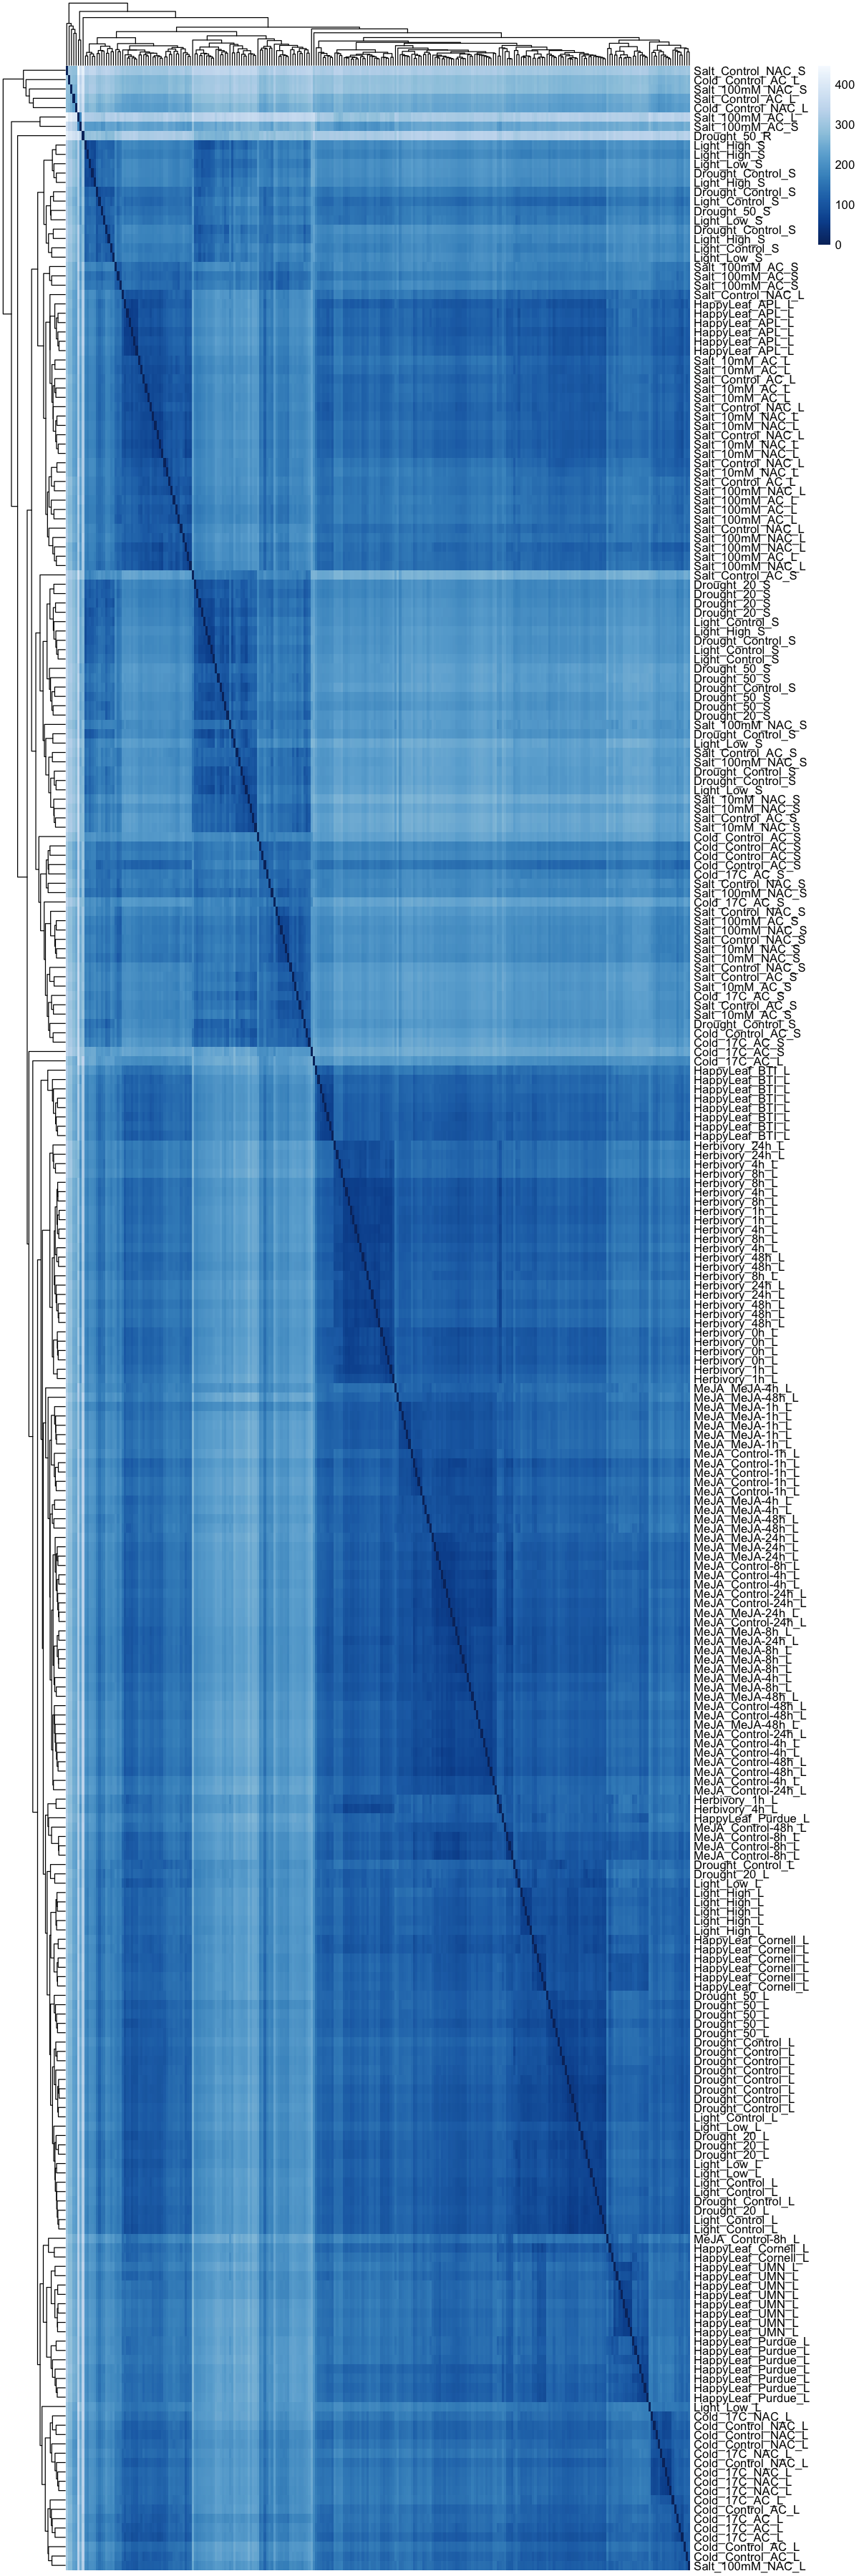

In [12]:
options(repr.plot.width=10, repr.plot.height=30)

# library("PoiClaClu")
# poisd <- PoissonDistance(t(counts(dds)))
# samplePoisDistMatrix <- as.matrix( poisd$dd )
# rownames(samplePoisDistMatrix) <- paste( dds$dex, dds$cell, sep=" - " )
# colnames(samplePoisDistMatrix) <- NULL
# pheatmap(samplePoisDistMatrix, clustering_distance_rows = poisd$dd, clustering_distance_cols = poisd$dd, col = colors)

sampleDists <- dist(t(assay(vsd)))
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( vsd$condition )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix, clustering_distance_rows = sampleDists, clustering_distance_cols = sampleDists, col = colors)

In [13]:
# options(repr.plot.width=4, repr.plot.height=3)
# plotPCA(vsd, intgroup = c("condition"))